In [1]:
import json
from collections import OrderedDict

import numpy as np

from pymatgen.util.testing import PymatgenTest
from pymatgen.analysis.defects import ValenceIonicRadiusEvaluator

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pymatgen.ext.matproj import MPRester

a = MPRester()
structure = a.get_structure_by_material_id("mp-24972") #TiO2: mp-390, fe2o3: mp-24972
#structure = PymatgenTest.get_structure("Si")
structure

Structure Summary
Lattice
    abc : 5.1375444305168338 5.4837876298260859 5.1375444008897855
 angles : 62.067550317265585 119.99999828294702 117.93245659283009
 volume : 105.4300472549721
      A : -1.6529157999999999 -4.2413729900000003 2.3818033700000001
      B : 1.62300387 4.2209269200000001 3.10186414
      C : -2.8991580899999998 4.2413729900000003 0.0
PeriodicSite: Fe (-2.3609, 1.4978, 1.0287) [0.3534, 0.0603, 0.6466]
PeriodicSite: Fe (-2.0028, 4.8541, 1.7131) [0.1466, 0.4397, 0.8534]
PeriodicSite: Fe (-0.5682, 2.7232, 4.4550) [0.6466, 0.9397, 0.3534]
PeriodicSite: Fe (-0.9263, -0.6332, 3.7705) [0.8534, 0.5603, 0.1466]
PeriodicSite: O (0.1483, 1.0450, 3.6442) [0.5533, 0.7500, 0.0533]
PeriodicSite: O (-0.4911, 4.0001, 2.9218) [0.2500, 0.7500, 0.4467]
PeriodicSite: O (-0.4070, 1.8898, 0.9023) [0.0532, 0.2500, 0.2500]
PeriodicSite: O (-2.4379, 0.2207, 2.5618) [0.7500, 0.2500, 0.5532]
PeriodicSite: O (-3.0775, 3.1759, 1.8396) [0.4468, 0.2500, 0.9468]
PeriodicSite: O (-2.5220, 2.3313

s = structure[4]
print(s.coords.tolist())
print(s.species_and_occu.as_dict())
print(s.as_dict()["properties"])

# site descriptor

In [3]:
from matminer.descriptors.structure import StructuralAttribute

def get_site_features(s, site_idx):
    vire = ValenceIonicRadiusEvaluator(s)
    if np.linalg.norm(s[site_idx].coords - vire.structure[site_idx].coords) > 1e-6:
        raise RuntimeError("Mismatch between input structure and VIRE structure.")
    sa = StructuralAttribute(vire.structure)
    nn = sa.get_neighbors_of_site_with_index(site_idx)

    rn = vire.radii[vire.structure[site_idx].species_string]
    bond_lengths = [s[site_idx].distance_from_point(x.coords) * (vire.radii[x.species_string]/(rn+vire.radii[x.species_string])) for x in nn]
    #bond_lengths = [s[site_idx].distance_from_point(x.coords) for x in nn]
    # Z, valence, coordination number, weighted avg bond length
    return vire.structure[site_idx].specie.number, vire.valences[vire.structure[site_idx].species_string], len(nn),  np.mean(bond_lengths) #, np.std(bond_lengths)

In [4]:
for j,s in enumerate(structure):
    f = get_site_features(structure, j)
    print(f)

(26, 3, 6, 1.3084618326540276)
(26, 3, 6, 1.3084618326540283)
(26, 3, 6, 1.3084138707805273)
(26, 3, 6, 1.308413870780528)
(8, -2, 4, 0.74768356004841496)
(8, -2, 4, 0.74768354088568634)
(8, -2, 4, 0.74767399792154865)
(8, -2, 4, 0.74767397162488791)
(8, -2, 4, 0.74767399679506086)
(8, -2, 4, 0.74768356718363971)


In [7]:
# vorocf = VoronoiCoordFinder(structure)
# neighsites = vorocf.get_coordinated_sites(n, tol, target_spec)


# Fetch and Process data

In [1]:
from pymongo import MongoClient

conn = MongoClient("localhost", port=57003)
db = conn["feff_km_share"]
db.authenticate("anon", "anon")
xas = db["xas"]

In [18]:
xas_ids = [u'mp-505011-28-XANES-K', u'mp-27845-17-XANES-K',
      u'mp-25537-1-XANES-K', u'mp-510006-20-XANES-K',
             u'mp-24279-40-XANES-K']
xas_ids = ['11028-2', '10729-2', '1072-10', '10685-2', '10734-1', '10670-1', 
           '1069-0', '1072-17', '1074-38', '1074-18', '11026-5', '1074-16',
           '10754-4', '10651-1', '1074-50', '1074-23', '10670-5', '10694-3', 
           '1074-27', '10674-0', '11025-19', '11031-0', '10754-2', '11026-3']
#xas_ids = [u'mp-28993-0-XANES-K', u'mp-10965-7-XANES-K', 
#           u'mp-38284-12-XANES-K', u'mp-31557-50-XANES-K', 
#           u'mp-11000-16-XANES-K']

In [19]:
spectra = []
for xas_id in xas_ids:
    for d in xas.find({"xas_id": "mp-{}-XANES-K".format(xas_id)}):
        print(xas_id)
        spectra.append(d["spectrum"])
        print(d["edge"])

11028-2
K
10729-2
K
1072-10
K
10685-2
K
10734-1
K
10670-1
K
1069-0
K
1072-17
K
1074-38
K
1074-18
K
11026-5
K
1074-16
K
10754-4
K
10651-1
K
1074-50
K
1074-23
K
10670-5
K
10694-3
K
1074-27
K
10674-0
K
11025-19
K
11031-0
K
10754-2
K
11026-3
K


xas_ids = []
spectra = []

i, N = 0, 49
for d in xas.find():
    xas_ids.append(d['xas_id'])
    spectra.append(d["spectrum"])
    i += 1
    print(i)
    if i>=N:
        break

In [20]:
len(xas_ids)

24

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import numpy as np

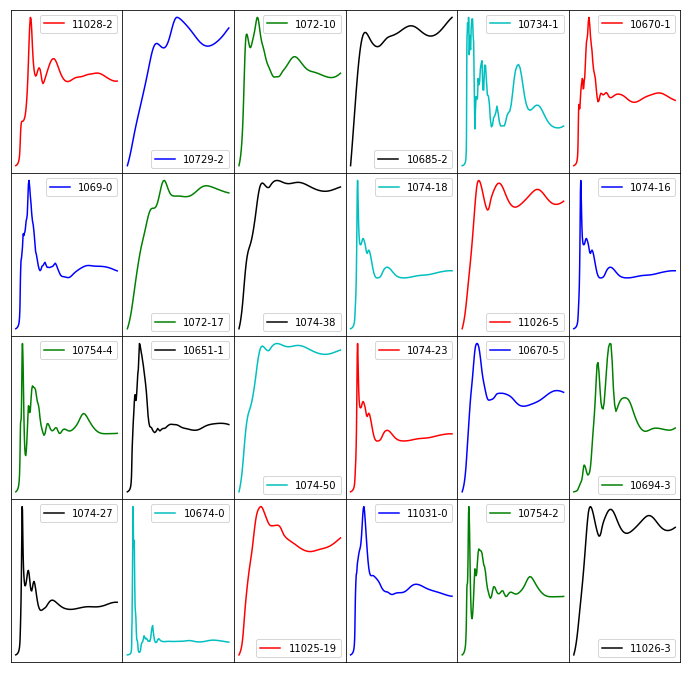

In [22]:
from itertools import cycle
plt.figure(figsize=(12, 12))

# gridspec inside gridspec                                                                     
gs = gridspec.GridSpec(4,6, wspace=0.0, hspace=0.0)
colors = cycle(["r", "b", "g", "k", "c"])

for i in range(len(xas_ids)):
    s = np.array(spectra[i])
    ax = plt.subplot(gs[i])
    ax.plot(s[:,0], s[:,3], next(colors), label=xas_ids[i].split("-XANES-K")[0])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc="best")
#plt.legend)
plt.savefig("K_xanes_sample.pdf")
plt.show() 
#11028-2, 10729-2, 1072-10, 10685-2, 10734-1, 10670-1, 1069-0, 1072-17,1074-38, 1074-18, 11026-5, 1074-16
#10754-4, 10651-1, 1074-50, 1074-23, 10670-5, 10694-3, 1074-27, 10674-0, 11025-19, 11031-0, 10754-2, 11026-3


# Process data with site properties

In [2]:
data_file = '/home/km/Google_Drive/LBL/FEFF/predict/all_data_120000.json'
with open(data_file, "r") as f:
    all_data = json.load(f)

In [3]:
# [[site, chi], ...]
all_data_processed = []
for k, v in all_data.items():
    tmp = np.array(v["spectrum"])
    # only mu
    try:
        chi = tmp[:,3]
    except:
        print(tmp.shape)
        continue
    all_data_processed.append([ list(v["site"]), chi.tolist(), k])

(0,)


In [4]:
processed_data_file = '/home/km/Google_Drive/LBL/FEFF/predict/all_data_processed_120000.json'
with open(processed_data_file, "w") as f:
    json.dump(all_data_processed, f)

In [5]:
all_data_processed[4][2]

'mp-10412-2-XANES-K'

In [12]:
all_lens = []
for l in all_data_processed:
    all_lens.append(len(l[1]))

In [13]:
print(min(all_lens), max(all_lens))

100 100


In [14]:
np_data = np.array(all_data_processed)

In [15]:
np_data[:, 0] 

array([list([81, 1, 3, 1.83642540632807]),
       list([8, -2, 1, 0.4002021051031206]),
       list([8, -2, 1, 0.4867821867988994]), ...,
       list([13, 0, 5, 1.3903850073608175]),
       list([73, 2, 3, 1.016849678798427]),
       list([38, 2, 5, 1.253205140556687])], dtype=object)

# Process data with snap site properties

In [1]:
import json
from pymongo import MongoClient

conn = MongoClient("localhost", port=57003)
db = conn["feff_km_share"]
db.authenticate("anon", "anon")
xas = db["xas"]

In [2]:
data_file = '/home/km/Google_Drive/LBL/FEFF/predict/snap/snap_data_150000.json'
with open(data_file, "r") as f:
    all_data = json.load(f)

In [3]:
from pymatgen import Structure
def get_Z(xas_id):
    d = xas.find_one({"xas_id":xas_id})
    structure = Structure.from_dict(d["structure"])
    return structure[d["absorbing_atom"]].specie.number

In [4]:
import numpy as np

# [[site, spectrum], ...]
# site -> [Z, bispectrum coeffs]
# spectrum -> [e_min, e_max, mu/max(mu)]
all_data_processed = []
for k, v in all_data.items():
    sf = list(v["site"])
    site_features = []
    # if atomic number is missing
    if len(sf) != 31:
        site_features = [get_Z(k)]
        
    tmp = np.array(v["spectrum"])
    
    # e_min, e_max, mu/ max mu
    try:
        mu = tmp[:,3]/max(tmp[:,3])
    except:
        print(tmp.shape)
        continue
        
    mu_list = [min(tmp[:,0]), max(tmp[:,0])]
    mu_list.extend(mu.tolist())
    
    site_features.extend(sf)
    
    all_data_processed.append([site_features, mu_list, k])

(0,)


In [5]:
processed_data_file = '/home/km/Google_Drive/LBL/FEFF/predict/snap/snap_data_processed_150000.json'
with open(processed_data_file, "w") as f:
    json.dump(all_data_processed, f)

In [6]:
all_data_processed[4][2]

'mp-15885-5-XANES-K'

In [7]:
# atomic number
all_data_processed[45][0][0]

39

In [8]:
# e_min, e_max
all_data_processed[45][1][:2]

[17051.719000000001, 17106.881000000001]

In [9]:
all_lens = []
for l in all_data_processed:
    all_lens.append(len(l[1]))

In [10]:
print(min(all_lens), max(all_lens))

102 102


In [ ]:
# %load /home/km/Google_Drive/LBL/FEFF/scripts/eq_sites.py
import numpy as np
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


class SymmSites:
    def __init__(self, structure):
        self.structure = structure
        sa = SpacegroupAnalyzer(self.structure)
        symm_data = sa.get_symmetry_dataset()
        # equivalency mapping for the structure
        # i'th site in the input structure equivalent to eq_atoms[i]'th site
        self.eq_atoms = symm_data["equivalent_atoms"]
        
    def get_unique_site_indices(self):
        """
        returns unique site indices in the structure
        """
        return np.unique(self.eq_atoms)

    def get_equivalent_site_indices(self, i):
        """
        returns site indices in the structure that are equivalent to the given site i
        """
        return np.argwhere(self.eq_atoms == self.eq_atoms[i]).squeeze()

    
if __name__ == "__main__":
    
    from pymatgen.ext.matproj import MPRester
    
    a = MPRester()
    structure = a.get_structure_by_material_id("mp-24972") #TiO2: mp-390, fe2o3: mp-24972
    symsite = SymmSites(structure)
    print(symsite.get_unique_site_indices())
    print(symsite.get_equivalent_site_indices(5))


In [89]:
structure

Structure Summary
Lattice
    abc : 5.1375444305168338 5.4837876298260859 5.1375444008897855
 angles : 62.067550317265585 119.99999828294702 117.93245659283009
 volume : 105.4300472549721
      A : -1.6529157999999999 -4.2413729900000003 2.3818033700000001
      B : 1.62300387 4.2209269200000001 3.10186414
      C : -2.8991580899999998 4.2413729900000003 0.0
PeriodicSite: Fe (-2.3609, 1.4978, 1.0287) [0.3534, 0.0603, 0.6466]
PeriodicSite: Fe (-2.0028, 4.8541, 1.7131) [0.1466, 0.4397, 0.8534]
PeriodicSite: Fe (-0.5682, 2.7232, 4.4550) [0.6466, 0.9397, 0.3534]
PeriodicSite: Fe (-0.9263, -0.6332, 3.7705) [0.8534, 0.5603, 0.1466]
PeriodicSite: O (0.1483, 1.0450, 3.6442) [0.5533, 0.7500, 0.0533]
PeriodicSite: O (-0.4911, 4.0001, 2.9218) [0.2500, 0.7500, 0.4467]
PeriodicSite: O (-0.4070, 1.8898, 0.9023) [0.0532, 0.2500, 0.2500]
PeriodicSite: O (-2.4379, 0.2207, 2.5618) [0.7500, 0.2500, 0.5532]
PeriodicSite: O (-3.0775, 3.1759, 1.8396) [0.4468, 0.2500, 0.9468]
PeriodicSite: O (-2.5220, 2.3313

In [90]:
symsite = SymmSites(structure)
symsite.get_unique_site_indices()

array([0, 4], dtype=int32)

In [91]:
symsite.get_equivalent_site_indices(5)

array([4, 5, 6, 7, 8, 9])

# Chemenv

In [ ]:
from pymatgen.analysis.chemenv.utils.chemenv_config import ChemEnvConfig
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimplestChemenvStrategy
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimpleAbundanceChemenvStrategy
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import TargettedPenaltiedAbundanceChemenvStrategy
from pymatgen.analysis.chemenv.utils.chemenv_errors import NeighborsNotComputedChemenvError
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometries import UNCLEAR_ENVIRONMENT_SYMBOL
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometries import AllCoordinationGeometries

In [2]:
#with open("/home/km/.chemenv/config.json", 'r') as f:
#    config_dict = json.load(f)   
config_dict = {'materials_project_configuration': None,
               'package_options': {
                   'default_max_distance_factor': 1.5,
                   'default_strategy': {
                       'strategy': 'SimplestChemenvStrategy',
                       'strategy_options': {'additional_condition': 1,
                                            'angle_cutoff': 0.3, 
                                            'continuous_symmetry_measure_cutoff': 10.0,
                                            'distance_cutoff': 1.4
                                           }
                   }
               }
              }

In [3]:
cec = ChemEnvConfig(materials_project_configuration=config_dict['materials_project_configuration'], 
                    package_options=config_dict['package_options'])

In [39]:
strategies_class_lookup = OrderedDict()
strategies_class_lookup['SimplestChemenvStrategy'] = SimplestChemenvStrategy
strategies_class_lookup['SimpleAbundanceChemenvStrategy'] = SimpleAbundanceChemenvStrategy
strategies_class_lookup['TargettedPenaltiedAbundanceChemenvStrategy'] = TargettedPenaltiedAbundanceChemenvStrategy

In [40]:
allcg = AllCoordinationGeometries()
strategy_class = strategies_class_lookup[cec.package_options['default_strategy']['strategy']]
default_strategy = strategy_class()
default_strategy.setup_options(cec.package_options['default_strategy']['strategy_options'])
max_dist_factor = cec.package_options['default_max_distance_factor']

In [41]:
# Compute environment
lgf = LocalGeometryFinder()
lgf.setup_parameters()
lgf.setup_structure(structure)
se = lgf.compute_structure_environments(maximum_distance_factor=max_dist_factor)

In [42]:
strategy = default_strategy
print(strategy.as_dict())

{'@module': 'pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies', '@class': 'SimplestChemenvStrategy', 'distance_cutoff': 1.4, 'angle_cutoff': 0.3, 'additional_condition': 1, 'symmetry_measure_type': 'csm_wcs_ctwcc', 'continuous_symmetry_measure_cutoff': 10.0}


In [43]:
strategy.set_structure_environments(se)

In [44]:
strategy.uniquely_determines_coordination_environments

True

In [45]:
se.equivalent_sites

[[PeriodicSite: Ti (0.0000, 0.0000, 4.8622) [0.0000, 0.0000, 0.5000]],
 [PeriodicSite: Ti (0.0000, 1.9031, 7.2933) [0.0000, 0.5000, 0.7500]],
 [PeriodicSite: Ti (1.9031, 1.9031, 0.0000) [0.5000, 0.5000, 0.0000]],
 [PeriodicSite: Ti (1.9031, 0.0000, 2.4311) [0.5000, 0.0000, 0.2500]],
 [PeriodicSite: O (1.9031, 0.0000, 4.4383) [0.5000, 0.0000, 0.4564]],
 [PeriodicSite: O (0.0000, 0.0000, 6.8694) [0.0000, 0.0000, 0.7064]],
 [PeriodicSite: O (0.0000, 1.9031, 5.2860) [0.0000, 0.5000, 0.5436]],
 [PeriodicSite: O (1.9031, 1.9031, 7.7171) [0.5000, 0.5000, 0.7936]],
 [PeriodicSite: O (0.0000, 1.9031, 9.3005) [0.0000, 0.5000, 0.9564]],
 [PeriodicSite: O (1.9031, 1.9031, 2.0072) [0.5000, 0.5000, 0.2064]],
 [PeriodicSite: O (1.9031, 0.0000, 0.4239) [0.5000, 0.0000, 0.0436]],
 [PeriodicSite: O (0.0000, 0.0000, 2.8549) [0.0000, 0.0000, 0.2936]]]

In [50]:
ces = strategy.get_site_coordination_environments(se.equivalent_sites[4][0])

In [51]:
ces[0]

('TS:3',
 {'algo': 'EXPLICIT_PERMUTATIONS',
  'detailed_voronoi_index': {'cn': 3, 'index': 0},
  'local2perfect_map': {0: 2, 1: 0, 2: 1},
  'other_symmetry_measures': {'csm_wcs_csc': 3.1512184058025223,
   'csm_wcs_ctwcc': 1.7825613813015815,
   'csm_wcs_ctwocc': 1.9516001646735213,
   'csm_wocs_csc': 3.1512184058025223,
   'csm_wocs_ctwcc': 1.3847431583242751,
   'csm_wocs_ctwocc': 1.246514723566057,
   'rotation_matrix_wcs_csc': array([[-1., -0., -0.],
          [ 0.,  1.,  0.],
          [-0., -0., -1.]]),
   'rotation_matrix_wcs_ctwcc': array([[-1., -0., -0.],
          [ 0.,  1.,  0.],
          [-0., -0., -1.]]),
   'rotation_matrix_wcs_ctwocc': array([[ -1.00000000e+00,  -0.00000000e+00,  -3.33058448e-17],
          [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
          [  3.33058448e-17,  -0.00000000e+00,  -1.00000000e+00]]),
   'rotation_matrix_wocs_csc': array([[-1., -0., -0.],
          [ 0.,  1.,  0.],
          [-0., -0., -1.]]),
   'rotation_matrix_wocs_ctwcc':

In [15]:
thecg = allcg.get_geometry_from_mp_symbol(ces[0][0])

In [16]:
thecg.coordination_number

6

In [ ]:
# regression net: l2 loss
# get xas
# get corresponding structure
# compute local env using chemenv
# get the coord number of the absorbing site
# findout how to encode absorbing atom --> use atomic number and valency(computed by pymatgen?)
# append coordination number, avg bond lengths and the bond length deviation

In [72]:
# everything together

for eqslist in se.equivalent_sites:
    site = eqslist[0]
    isite = se.structure.index(site)
    try:
        if strategy.uniquely_determines_coordination_environments:
            ces = strategy.get_site_coordination_environments(site)
        else:
            ces = strategy.get_site_coordination_environments_fractions(site)
    except NeighborsNotComputedChemenvError:
        print("error")
        continue
    if ces is None:
        continue
    if len(ces) == 0:
        continue
    comp = site.species_and_occu
    #ce = strategy.get_site_coordination_environment(site)
    if strategy.uniquely_determines_coordination_environments:
        ce = ces[0]
        if ce is None:
            continue
        thecg = allcg.get_geometry_from_mp_symbol(ce[0])
        mystring = 'Environment for site #{} {} ({}) : {} ({})\n'.format(str(isite),
                                                                         comp.get_reduced_formula_and_factor()[0],
                                                                         str(comp),
                                                                         thecg.name,
                                                                         ce[0])
    else:
        mystring = 'Environments for site #{} {} ({}) : \n'.format(str(isite),
                                                                   comp.get_reduced_formula_and_factor()[0],
                                                                   str(comp))
        for ce in ces:
            cg = allcg.get_geometry_from_mp_symbol(ce[0])
            csm = ce[1]['other_symmetry_measures']['csm_wcs_ctwcc']
            mystring += ' - {} ({}): {:.2f} % (csm : {:2f})\n'.format(cg.name, cg.mp_symbol,
                                                                      100.0*ce[2],
                                                                      csm)
    if strategy.uniquely_determines_coordination_environments:
                    if thecg.mp_symbol != UNCLEAR_ENVIRONMENT_SYMBOL:
                        mystring += '  <Continuous symmetry measures>  '
                        mingeoms = se.ce_list[isite][thecg.coordination_number][0].minimum_geometries()
                        for mingeom in mingeoms:
                            csm = mingeom[1]['other_symmetry_measures']['csm_wcs_ctwcc']
                            mystring += '{} : {:.2f}       '.format(mingeom[0], csm)
    print(mystring)       

Environment for site #0 Ti (Ti1) : Octahedron (O:6)
  <Continuous symmetry measures>  O:6 : 3.15       T:6 : 12.24       PP:6 : 22.93       
Environment for site #1 Ti (Ti1) : Octahedron (O:6)
  <Continuous symmetry measures>  O:6 : 3.15       T:6 : 12.24       PP:6 : 22.93       
Environment for site #2 Ti (Ti1) : Octahedron (O:6)
  <Continuous symmetry measures>  O:6 : 3.15       T:6 : 12.24       PP:6 : 22.93       
Environment for site #3 Ti (Ti1) : Octahedron (O:6)
  <Continuous symmetry measures>  O:6 : 3.15       T:6 : 12.24       PP:6 : 22.93       
Environment for site #4 O2 (O1) : T-shaped (TS:3)
  <Continuous symmetry measures>  TS:3 : 1.78       TL:3 : 3.20       TY:3 : 6.06       
Environment for site #5 O2 (O1) : T-shaped (TS:3)
  <Continuous symmetry measures>  TS:3 : 1.78       TL:3 : 3.20       TY:3 : 6.06       
Environment for site #6 O2 (O1) : T-shaped (TS:3)
  <Continuous symmetry measures>  TS:3 : 1.78       TL:3 : 3.20       TY:3 : 6.06       
Environment for sit

In [ ]:
#se.plot_environments(isite, additional_condition=se.AC.ONLY_ACB)

In [3]:
struct_si

Structure Summary
Lattice
    abc : 3.8401979336999998 3.8401989943442438 3.8401979337177736
 angles : 119.99999086398421 90.0 60.000009137322209
 volume : 40.044794644251589
      A : 3.8401979336999998 0.0 0.0
      B : 1.9200989667999999 3.3257101909000002 0.0
      C : 0.0 -2.2171384942999999 3.1355090603
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (3.8402, 0.0000, 2.3516) [0.7500, 0.5000, 0.7500]

In [5]:
chemenv_config = ChemEnvConfig.auto_load()
chemenv_config.setup()

Unable to load configuration from file "/home/km/.chemenv/config.json" ...
 ... loading default configuration

=> Configuration of the ChemEnv package <=
Current configuration :
 - No access to materials project
 - Package options :
     default_max_distance_factor   :   1.5
     default_strategy   :   {'strategy': 'SimplestChemenvStrategy', 'strategy_options': {'continuous_symmetry_measure_cutoff': 10.0, 'additional_condition': 1, 'angle_cutoff': 0.3, 'distance_cutoff': 1.4}}

Choose in the following :
 <1> + <ENTER> : setup of the access to the materials project database
 <2> + <ENTER> : configuration of the package options (strategy, ...)
 <q> + <ENTER> : quit without saving configuration


KeyboardInterrupt: 